<a href="https://colab.research.google.com/github/WenqiLiao/Underground_Utilities/blob/main/AngleCostFunctionAndEdgeSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import linemerge
from shapely.wkt import loads
from shapely.geometry import LineString
from shapely.geometry import Point, Polygon
from scipy.spatial import Delaunay

In [3]:
df_point = gpd.read_file('/content/hydrant_location.shp')
df_point['id'] = df_point.reset_index().index
df_point

id                    geometry
0        0  POINT (-74.00698 40.74748)
1        1  POINT (-74.00722 40.74722)
2        2  POINT (-74.00721 40.74697)
3        3  POINT (-74.00722 40.74722)
4        4  POINT (-74.00728 40.74667)
...    ...                         ...
2295  2295  POINT (-73.97976 40.71559)
2296  2296  POINT (-73.97987 40.71361)
2297  2297  POINT (-73.98387 40.72077)
2298  2298  POINT (-73.97780 40.71833)
2299  2299  POINT (-73.99446 40.72987)

[2300 rows x 2 columns]

In [4]:
df_road = gpd.read_file('/content/road_locations.shp')
# df_road.drop('road_id', axis=1, inplace=True)
df_road

id   Road_Name                                           geometry
0      1    Front St  LINESTRING (-74.01301 40.70215, -74.01167 40.7...
1      1    Front St  LINESTRING (-74.01171 40.70247, -74.00999 40.7...
2      1    Front St  LINESTRING (-74.00577 40.70566, -74.00396 40.7...
3      1    Front St  LINESTRING (-74.00385 40.70651, -74.00142 40.7...
4      2       Water  LINESTRING (-74.01270 40.70275, -74.01180 40.7...
..   ...         ...                                                ...
331  248  Kenmare St  LINESTRING (-73.99741 40.72164, -73.99389 40.7...
332  249    Duane St  LINESTRING (-74.00203 40.71159, -74.00252 40.7...
333  250   City Hall  LINESTRING (-74.00296 40.71334, -74.00150 40.7...
334  251       Dutch  LINESTRING (-74.00799 40.70899, -74.00720 40.7...
335  252    Edgar St  LINESTRING (-74.01411 40.70697, -74.01368 40.7...

[336 rows x 3 columns]

In [5]:
def find_closest_road(point, roads_df, min_distance):
    closest_road_id = []

    for idx, road in roads_df.iterrows():
        distance = point.distance(road['geometry'])
        if distance < min_distance:
            closest_road_id.append(road['id'])

    return closest_road_id

In [6]:
df_point['closest_road_id'] = df_point.apply(lambda row: find_closest_road(row['geometry'], df_road, 0.0003), axis=1)
# df_point

In [7]:
def blockInfo(shapefile):
    gdf = gpd.read_file(shapefile)
    block_info_list = []
    for idx, row in gdf.iterrows():
        block_id = row['id']
        polygon = row['geometry']
        corners = list(polygon.exterior.coords)
        block_info = {
            'blockID': block_id,
            'corners': corners
        }
        block_info_list.append(block_info)
    return block_info_list

In [8]:
def blockIdentify(hydrantCenter, blocks):
    hydrantPoint = Point(hydrantCenter)
    for block in blocks:
        blockCoords = block['corners']
        blockPolygon = Polygon(blockCoords)
        if hydrantPoint.within(blockPolygon):
            hydrantBlockID = block['blockID']
            return hydrantBlockID
    return None

In [9]:
blocks = blockInfo("/content/1920s_blocks_complete.shp")
df_point['block_id'] = df_point.apply(lambda row: blockIdentify(row['geometry'], blocks), axis=1)

In [10]:
# Check if the entire dataframe contains NA values
is_na_anywhere = df_point.isna().any().any()

print("Dataframe contains NA values:", is_na_anywhere)

Dataframe contains NA values: True


In [11]:
df_point

id                    geometry closest_road_id  block_id
0        0  POINT (-74.00698 40.74748)           [119]       1.0
1        1  POINT (-74.00722 40.74722)      [119, 170]       2.0
2        2  POINT (-74.00721 40.74697)           [120]       2.0
3        3  POINT (-74.00722 40.74722)      [119, 170]       2.0
4        4  POINT (-74.00728 40.74667)           [120]       3.0
...    ...                         ...             ...       ...
2295  2295  POINT (-73.97976 40.71559)           [234]     505.0
2296  2296  POINT (-73.97987 40.71361)   [30, 35, 235]     901.0
2297  2297  POINT (-73.98387 40.72077)           [221]     437.0
2298  2298  POINT (-73.97780 40.71833)      [199, 235]     444.0
2299  2299  POINT (-73.99446 40.72987)      [187, 109]     329.0

[2300 rows x 4 columns]

In [12]:
class Hydrant:

    def __init__(self, id, x, y, closest_road_id): # constructor

        # From shapefile
        self.pointID = id
        self.x = x
        self.y = y
        self.blockID = 0
        self.roadID = closest_road_id

        # Will initialize once into network generation
        self.branchID = 0
        self.neighbor = [] # List to store all the neighbors of this hydrant
        self.edge = {} # Dict to store edge information

In [13]:
# Create an empty list to store the 'hydrant' instances
hydrant_instances = []

# Iterate through each row in the DataFrame and create 'hydrant' instances
for index, row in df_point.iterrows():
    # Get the Point object from the 'geometry' column
    point = row['geometry']

    # Extract 'x' and 'y' coordinates from the Point object
    x, y = point.x, point.y

    # Create 'hydrant' instance and add it to the list
    hydrant_obj = Hydrant(row['id'], x, y, row['closest_road_id'])
    hydrant_instances.append(hydrant_obj)

In [14]:
# Set to store filtered edges (edges that don't exceed the maximum length)
filtered_edges_cp = set()

In [15]:
# Extract x and y coordinates from hydrant instances
hydrant_points = [(hydrant.x, hydrant.y) for hydrant in hydrant_instances]

# Convert the list of points to a numpy array
points = np.array(hydrant_points)

# Perform Delaunay triangulation
triangulation = Delaunay(points)

In [16]:
# Function to calculate the Euclidean distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [17]:
# Threshold for maximum allowed edge length
max_edge_length = 0.002

In [18]:
# Set to store filtered edges (edges that don't exceed the maximum length)
filtered_edges = set()

In [19]:
class Edge:

    def __init__(self, id, coordinateX, coordinateY, length): # constructor

        self.edgeID = id
        self.coordinateX = coordinateX
        self.coordinateY = coordinateY
        self.length = length
        # self.cross_road_id = cross_road_id
        # self.angle_with_road = angle_with_road
        # self.intersection_angle = intersection_angle

In [20]:
# # Loop through each triangle (simplex)
# for simplex in triangulation.simplices:
#     # Get the indices of the points forming the edges of the triangle
#     edge1 = frozenset([simplex[0], simplex[1]])
#     edge2 = frozenset([simplex[1], simplex[2]])
#     edge3 = frozenset([simplex[0], simplex[2]])

#     # Get the actual points from the 'points' list using the indices
#     point1, point2, point3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]

#     # Check if any edge length exceeds the maximum allowed length
#     # If any edge length exceeds the limit, remove the corresponding edges from the set
#     if distance(point1, point2) <= max_edge_length:
#         filtered_edges_cp.add(edge1)
#     if distance(point2, point3) <= max_edge_length:
#         filtered_edges_cp.add(edge2)
#     if distance(point1, point3) <= max_edge_length:
#         filtered_edges_cp.add(edge3)

filtered_edges_cp = set()
edge_set = []
edge_id = 0
len(triangulation.simplices)



# Loop through each triangle (simplex)
for simplex in triangulation.simplices:
    # Get the indices of the points forming the edges of the triangle
    #####print(simplex[0], simplex[1], simplex[2])
    edge1 = frozenset([simplex[0], simplex[1]])
    edge2 = frozenset([simplex[1], simplex[2]])
    edge3 = frozenset([simplex[0], simplex[2]])

    # Get the actual points from the 'points' list using the indices
    point1, point2, point3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]
    #####print(point1, point2, point3)
    # Check if any edge length exceeds the maximum allowed length
    # If any edge length exceeds the limit, remove the corresponding edges from the set
    if distance(point1, point2) <= max_edge_length:
        filtered_edges_cp.add(edge1)
        edge_obj = Edge(edge_id, simplex[0], simplex[1], distance(point1, point2))
        edge_set.append(edge_obj)
        edge_id += 1
    if distance(point2, point3) <= max_edge_length:
        filtered_edges_cp.add(edge2)
        edge_obj = Edge(edge_id, simplex[1], simplex[2], distance(point2, point3))
        edge_set.append(edge_obj)
        edge_id += 1
    if distance(point1, point3) <= max_edge_length:
        filtered_edges_cp.add(edge3)
        edge_obj = Edge(edge_id, simplex[0], simplex[2], distance(point1, point3))
        edge_set.append(edge_obj)
        edge_id += 1

Streaming output truncated to the last 5000 lines.
first vertex: (-74.00603321447265, 40.71995452164479) second vertex: (-74.00623949511828, 40.71904191050519)
first vertex: (-74.00444820316642, 40.71902960232894) second vertex: (-74.00512260727463, 40.7181094936267)
first vertex: (-73.98937994434219, 40.73448388236273) second vertex: (-73.98936505496012, 40.73393297522617)
first vertex: (-73.99383329704396, 40.71050852339039) second vertex: (-73.99309701494433, 40.710622214008716)
first vertex: (-74.00721011501237, 40.70955115566477) second vertex: (-74.0082762222746, 40.70948631450946)
first vertex: (-73.98379949989051, 40.71143072667679) second vertex: (-73.98343661790412, 40.71177450961125)
first vertex: (-74.0097494544904, 40.72218569277703) second vertex: (-74.00967456534683, 40.72286343952642)
first vertex: (-73.99316991591057, 40.72143907191606) second vertex: (-73.99280897962484, 40.720470242938546)
first vertex: (-73.99537624114981, 40.712990768557184) second vertex: (-73.994

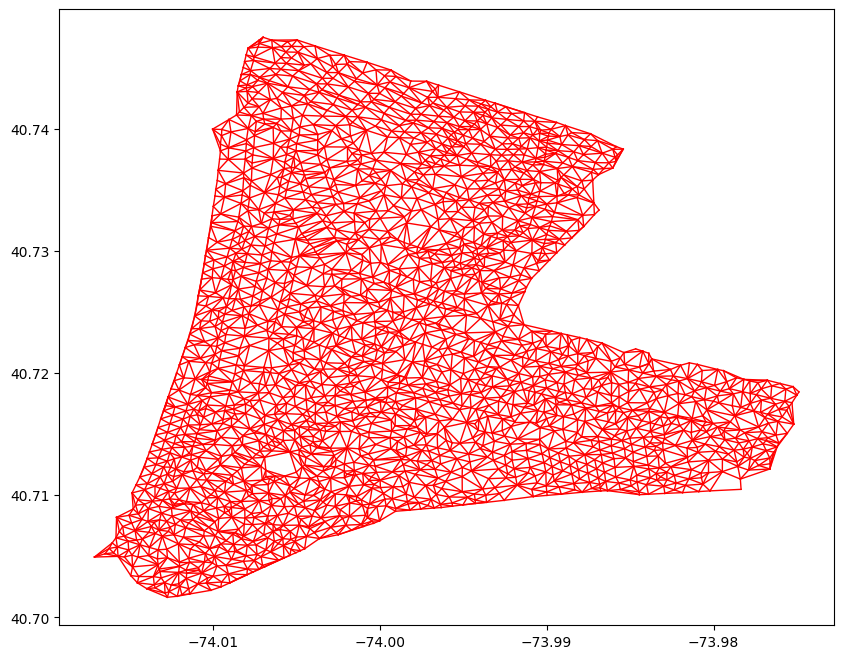

In [21]:
# Plot the filtered edges
plt.figure(figsize=(10, 8))
for edge in filtered_edges_cp:
    edge_points = list(edge)
    # print("X Coordinate:", np.array(points)[edge_points, 0], "Y Coordinate:", np.array(points)[edge_points, 1])
    first_vertex = (np.array(points)[edge_points, 0][0], np.array(points)[edge_points, 1][0])
    second_vertex = (np.array(points)[edge_points, 0][1], np.array(points)[edge_points, 1][1])
    print("first vertex:", first_vertex, "second vertex:", second_vertex)
    plt.plot(np.array(points)[edge_points, 0], np.array(points)[edge_points, 1], 'r-', linewidth=1)

In [34]:
import math

def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else:

        return ang_deg

# FOR GETTING THE CORRECT INTERIOR ANGLE, YOU MUST ORDER THE VERTICES CORRECTLY:
# the point connecting the 2 lines whose angle we are trying to calculate must be the second set of coordinates initialized when defining the line
lineA = ((1,1), (2,2)) #ED
lineB = ((3,1),(1,1)) #DF

# print("edge points")
# for edge in filtered_edges_cp:
#     edge_points = list(edge)
#     print(edge_points)
    # plt.plot(np.array(points)[edge_points, 0], np.array(points)[edge_points, 1], 'r-', linewidth=1)

# filtered_edges_list = list(filtered_edges_cp)

# for i in range(len(filtered_edges_list) - 1):
#     edge1_points = tuple(filtered_edges_list[i][0])
#     edge2_points = tuple(filtered_edges_list[i+1])
#     # print("edge 1:", edge1_points, "edge 2:", edge2_points)
#     # print("Angle between points: ", ang(edge1_points, edge2_points))



all_edges = []

print("len(filtered_edges_cp)", len(filtered_edges_cp))


for edge in filtered_edges_cp:
    edge_points = list(edge)
    # print("X Coordinate:", np.array(points)[edge_points, 0], "Y Coordinate:", np.array(points)[edge_points, 1])
    first_vertex = (np.array(points)[edge_points, 0][0], np.array(points)[edge_points, 1][0])
    second_vertex = (np.array(points)[edge_points, 0][1], np.array(points)[edge_points, 1][1])
    edge_endpoint = (first_vertex, second_vertex)
    # print("edge_endpoint", edge_endpoint)
    all_edges.append(tuple(edge_endpoint))

print("len(all_edges)", len(all_edges))

count = 0
neighboring_edges_adjacency_list = {}
for edge in all_edges:
  # print("edge endpoint:", edge[1])
  # count+=1
  target_coordinate = edge[0]
  for search_edge1 in all_edges:
    if search_edge1[0] == target_coordinate or search_edge1[1] == target_coordinate:
      if not(edge in neighboring_edges_adjacency_list):
          # print("new target key created")
          neighboring_edges_adjacency_list[edge] = []
      # print("new value added to target")
      neighboring_edges_adjacency_list[edge].append(search_edge1)
      # print("after adding the value:", neighboring_edges_adjacency_list[target])
  target_coordinate = edge[1]
  for search_edge2 in all_edges:
    if search_edge2[0] == target_coordinate or search_edge2[1] == target_coordinate:
      if not(edge in neighboring_edges_adjacency_list):
          # print("new target key created")
          neighboring_edges_adjacency_list[edge] = []
      # print("new value added to target")
      neighboring_edges_adjacency_list[edge].append(search_edge2)
      # print("after adding the value:", neighboring_edges_adjacency_list[target])
# print(count)


len(filtered_edges_cp) 6744
len(all_edges) 6744


In [35]:
print(len(neighboring_edges_adjacency_list))
edge_num = 0
for edge_key in neighboring_edges_adjacency_list:
  edge_num += 1
  print("edge:", edge_key, ", ", edge_num, "neighbors:", neighboring_edges_adjacency_list[edge_key])

Streaming output truncated to the last 5000 lines.
edge: ((-74.00603321447265, 40.71995452164479), (-74.00623949511828, 40.71904191050519)) ,  1745 neighbors: [((-74.00603321447265, 40.71995452164479), (-74.00576048185387, 40.71963830991288)), ((-74.00603321447265, 40.71995452164479), (-74.00623949511828, 40.71904191050519)), ((-74.0052703536694, 40.72027073337671), (-74.00603321447265, 40.71995452164479)), ((-74.00646800560403, 40.720428839242665), (-74.00603321447265, 40.71995452164479)), ((-74.00544427012196, 40.720646234808356), (-74.00603321447265, 40.71995452164479)), ((-74.00654310589036, 40.72002171663782), (-74.00603321447265, 40.71995452164479)), ((-74.00576048185387, 40.71963830991288), (-74.00623949511828, 40.71904191050519)), ((-74.00654310589036, 40.72002171663782), (-74.00623949511828, 40.71904191050519)), ((-74.00603321447265, 40.71995452164479), (-74.00623949511828, 40.71904191050519)), ((-74.00661179106616, 40.71839123110078), (-74.00623949511828, 40.71904191050519)),

In [25]:

# for key in neighboring_edges_adjacency_list:
#   print("Edge:", key, ", Neighbors:", neighboring_edges_adjacency_list[key])

print("Edge: ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)), Neighbors:")
for neighboring_edge in neighboring_edges_adjacency_list[((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464))]:
  print (str(neighboring_edge) + ",")

# for key in neighboring_edges_adjacency_list:
#   print("edge:", key, ",neigbors:", neighboring_edges_adjacency_list[key])


# print(neighboring_edges_adjacency_list)

# assigned_cost = 0
# for i in range(len(all_edges)-1):
#     angle = ang(all_edges[i], all_edges[i+1])
#     print("Angle between points: ", angle)
#     if (abs(360-angle) < 30):
#       assigned_cost = 1
#     elif (abs(90-angle) < abs(180-angle)):
#       assigned_cost = 0.8*(abs(90-angle)/60) + 0.2
#     elif ((abs(180-angle) < abs(180 - angle)) and abs(180 - angle) < (abs(270-angle))):
#       assigned_cost = 0.8*(abs(270-angle)/60) + 0.2
#     print ("assigned cost", assigned_cost)




Edge: ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)), Neighbors:
((-74.00997465792683, 40.70336902325146), (-74.00946034322489, 40.702898019261255)),
((-74.00997465792683, 40.70336902325146), (-74.01037080623364, 40.702815173605444)),
((-74.00905971914126, 40.70356392145431), (-74.00997465792683, 40.70336902325146)),
((-74.00997465792683, 40.70336902325146), (-74.00974186285121, 40.70421358213046)),
((-74.00997465792683, 40.70336902325146), (-74.01030490210387, 40.70323367727727)),
((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)),
((-74.01030490210387, 40.70323367727727), (-74.01066595977791, 40.70362349183464)),
((-74.01001528037351, 40.704465350239325), (-74.01066595977791, 40.70362349183464)),
((-74.01085043074308, 40.70385827306304), (-74.01066595977791, 40.70362349183464)),
((-74.01088061690102, 40.70273803120183), (-74.01066595977791, 40.70362349183464)),
((-74.01155477442826, 40.7036201378171), (-74.0106659597

In [47]:
import math
from sympy import Point, Line, pi


def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else:

        return ang_deg

# FOR GETTING THE CORRECT INTERIOR ANGLE, YOU MUST ORDER THE VERTICES CORRECTLY:
# the point connecting the 2 lines whose angle we are trying to calculate must be the second set of coordinates initialized when defining the line
lineA = Line((1,1), (2,2)) #ED
lineB = Line((3,1),(1,1)) #DF
# print("line between:", lineA.angle_between(lineB))

angle_filtered_edges = []

for edge_key in neighboring_edges_adjacency_list:
  # print("is it a tuple?", neighboring_edges_adjacency_list[edge_key])
  # print("edge key:", edge_key)
  for neighboring_edge in neighboring_edges_adjacency_list[edge_key]:
    # print("neighbor:", neighboring_edge)
    try:
      angle = ang(edge_key, neighboring_edge)
      # print ("angle between edge and neighboring edges:", angle)
      # print(angle)
      if(angle > 160):
        angle_filtered_edges.append(edge_key)
      # print("YAY!")
    except ValueError:
      # raise Exception("error calculating angles")
      print("ERROR CALCULATING ANGLE")
    # print(angle_filtered_edges)

print(angle_filtered_edges)




Streaming output truncated to the last 5000 lines.
23.804705942943
0.0
19.30861860267164
120.26775245209141
3.7468548983112506
68.50465132596912
144.49829370867275
0.0
78.363053244759
8.245655226960508
126.8435070674092
147.75977349975685
1.2074182697257333e-06
108.58730553004132
2.1017465027606828
28.13244422708321
110.59101765172755
103.73195975043586
81.40788074855041
1.2074182697257333e-06
49.16503242837619
139.28835025575745
50.558465996001985
105.4847115038535
100.25049189250699
37.431602978935835
0.0
41.82266176040272
36.379190764661516
27.80823746704361
136.27211987390135
104.39511563370594
177.83727666516063
0.0
120.70350589384503
131.51346880808825
169.6462292002817
0.0
149.47682525518823
150.30154022802571
53.31825702674859
84.67063447871075
31.69158717024998
0.0
93.80093058690318
141.17489885185395
75.56737042297769
178.8028484794898
1.2074182697257333e-06
60.55759910464532
128.88251811099624
177.41768015447184
41.83836006647322
55.5732377799516
1.2074182697257333e-06
165.2

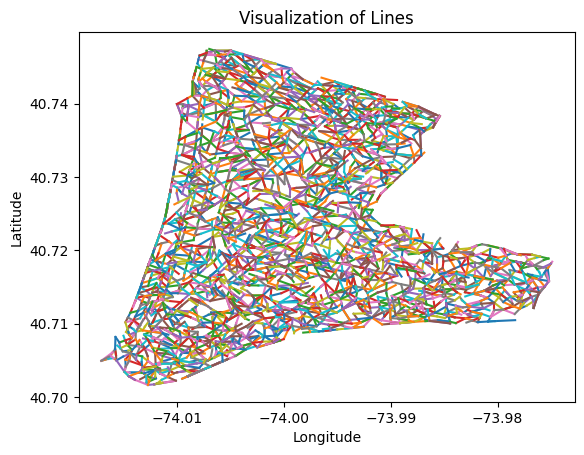

In [48]:
import matplotlib.pyplot as plt

# Your list of lines
# lines = [((-74.00997465792683, 40.70336902325146), (-74.00946034322489, 40.702898019261255)), ((-74.00997465792683, 40.70336902325146), (-74.00946034322489, 40.702898019261255)), ((-74.00997465792683, 40.70336902325146), (-74.00946034322489, 40.702898019261255)), ((-74.00997465792683, 40.70336902325146), (-74.00946034322489, 40.702898019261255)), ((-74.00997465792683, 40.70336902325146), (-74.01037080623364, 40.702815173605444)), ((-74.00997465792683, 40.70336902325146), (-74.01037080623364, 40.702815173605444)), ((-74.00997465792683, 40.70336902325146), (-74.01037080623364, 40.702815173605444)), ((-74.00997465792683, 40.70336902325146), (-74.01037080623364, 40.702815173605444)), ((-74.00905971914126, 40.70356392145431), (-74.00997465792683, 40.70336902325146)), ((-74.00905971914126, 40.70356392145431), (-74.00997465792683, 40.70336902325146)), ((-74.00905971914126, 40.70356392145431), (-74.00997465792683, 40.70336902325146)), ((-74.00905971914126, 40.70356392145431), (-74.00997465792683, 40.70336902325146)), ((-74.00997465792683, 40.70336902325146), (-74.00974186285121, 40.70421358213046)), ((-74.00997465792683, 40.70336902325146), (-74.00974186285121, 40.70421358213046)), ((-74.00997465792683, 40.70336902325146), (-74.01030490210387, 40.70323367727727)), ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)), ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)), ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)), ((-74.01030490210387, 40.70323367727727), (-74.01066595977791, 40.70362349183464)), ((-74.01030490210387, 40.70323367727727), (-74.01066595977791, 40.70362349183464)), ((-74.01001528037351, 40.704465350239325), (-74.01066595977791, 40.70362349183464)), ((-74.01001528037351, 40.704465350239325), (-74.01066595977791, 40.70362349183464)), ((-74.01001528037351, 40.704465350239325), (-74.01066595977791, 40.70362349183464)), ((-74.01085043074308, 40.70385827306304), (-74.01066595977791, 40.70362349183464)), ((-74.01085043074308, 40.70385827306304), (-74.01066595977791, 40.70362349183464)), ((-74.01085043074308, 40.70385827306304), (-74.01066595977791, 40.70362349183464)), ((-74.01088061690102, 40.70273803120183), (-74.01066595977791, 40.70362349183464)), ((-74.01088061690102, 40.70273803120183), (-74.01066595977791, 40.70362349183464)), ((-74.01088061690102, 40.70273803120183), (-74.01066595977791, 40.70362349183464)), ((-74.01088061690102, 40.70273803120183), (-74.01066595977791, 40.70362349183464)), ((-74.01155477442826, 40.7036201378171), (-74.01066595977791, 40.70362349183464)), ((-74.01155477442826, 40.7036201378171), (-74.01066595977791, 40.70362349183464)), ((-74.01155477442826, 40.7036201378171), (-74.01066595977791, 40.70362349183464)), ((-74.01155477442826, 40.7036201378171), (-74.01066595977791, 40.70362349183464)), ((-74.0115782525511, 40.703194177588436), (-74.01066595977791, 40.70362349183464)), ((-74.0115782525511, 40.703194177588436), (-74.01066595977791, 40.70362349183464)), ((-74.0115782525511, 40.703194177588436), (-74.01066595977791, 40.70362349183464)), ((-74.01049490488293, 40.70453578460784), (-74.01066595977791, 40.70362349183464)), ((-74.01049490488293, 40.70453578460784), (-74.01066595977791, 40.70362349183464)), ((-74.01049490488293, 40.70453578460784), (-74.01066595977791, 40.70362349183464)), ((-74.01049490488293, 40.70453578460784), (-74.01066595977791, 40.70362349183464)), ((-74.00974186285121, 40.70421358213046), (-74.01066595977791, 40.70362349183464)), ((-74.00974186285121, 40.70421358213046), (-74.01066595977791, 40.70362349183464)), ((-74.00974186285121, 40.70421358213046), (-74.01066595977791, 40.70362349183464)), ((-74.01085713877818, 40.70406622215104), (-74.01066595977791, 40.70362349183464)), ((-74.01085713877818, 40.70406622215104), (-74.01066595977791, 40.70362349183464)), ((-74.01085713877818, 40.70406622215104), (-74.01066595977791, 40.70362349183464)), ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)), ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464)), ((-74.00997465792683, 40.70336902325146), (-74.01066595977791, 40.70362349183464))]
# lines = all_edges
lines = angle_filtered_edges
# Extract x and y coordinates of each line
x_coords = [[line[0][0], line[1][0]] for line in lines]
y_coords = [[line[0][1], line[1][1]] for line in lines]

# Create a new plot
plt.figure()

# Plot each line on the same plot
for x, y in zip(x_coords, y_coords):
    plt.plot(x, y)

# Add labels and title (optional)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of Lines')

# Show the plot
plt.show()


In [ ]:
# -----Create a GeoDataFrame for filtered edges-----

# Create a list of LineString objects for filtered edges
lines = []
for edge in filtered_edges_cp:
    edge_points = list(edge)
    line = LineString(np.array(points)[edge_points])
    lines.append(line)


# Create a GeoDataFrame from the LineString objects
gdf_filtered_edges_cp = gpd.GeoDataFrame(geometry=lines)

# Save the GeoDataFrame as a shapefile
gdf_filtered_edges_cp.to_file('filtered_edges_cp.shp')



1.   Store all of the nodes with its neighbors in an adjacency list
2.   Assign a cost to each neighbor edge in the adjacency list (based on the cost function)
3. Select the cheapest edge to connect to the MST

